
### Radial Velocity computation, with pre-calibrated files

In this file I will work with the precalibrated spectra data from EXPRES given to me by Lily Zhao.


In [359]:
# Import my .py code 
# Run this to reimport without having to restart the whole notebook
import calibration_functions
import importlib
importlib.reload(calibration_functions)
from calibration_functions import *

In [444]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
from tqdm import tqdm
import pandas as pd
from datetime import datetime
from scipy.interpolate import interp1d

plt.rcParams['font.size'] = 16
plt.rc("font", family="serif")

from os import walk

In [17]:
# Loads real spectra from EXPREES (Lily) for star HD34411
REAL_SPECTRA_path = "/Users/jakobharteg/Data/34411_spectra/"
def get_all_spectra_filenames():
    SPEKTRA_filenames = next(walk(REAL_SPECTRA_path), (None, None, []))[2]  # [] if no file
    SPEKTRA_filenames = sorted(SPEKTRA_filenames)
    return SPEKTRA_filenames


# Load data from fits file for a given "real spectra file"
def load_spectra_fits(filename):
    path = REAL_SPECTRA_path  + "/" + filename
    hdul = fits.open(path)
    data = hdul[1].data.copy()
    hdul.close()
    return data

def get_spec_wavel(file, order, continuum_normalized=False, angstrom=False):
    data_spec       = file['spectrum'][order]
    data_spec_err   = file['uncertainty'][order]
    data_wavel      = file['wavelength'][order]

    if angstrom == False:
        data_wavel = angstrom_to_velocity(data_wavel) # convert angstrom to cm/s

    if continuum_normalized:
        cont = file['continuum'][order]
        data_spec = data_spec / cont
        data_spec_err = data_spec_err / cont

    return data_spec, data_spec_err, data_wavel

### Look at the dates of the files

In [5]:
def load_spektra_date(filename):
    path = REAL_SPECTRA_path  + "/" + filename
    hdul = fits.open(path)
    header = hdul[0].header
    hdul.close()
    return header["DATE-OBS"]


def get_spectra_dates(filenames):
    dates = []
    for i in np.arange(len(filenames)):
        date = load_spektra_date(filenames[i])
        date = date[:date.index(" ")]
        year, month, date = date.split("-")
        year, month, date = int(year), int(month), int(date)
        dates.append((year, month, date))
    return dates


# There are often several observations per night
def get_spectra_filenames_without_duplicate_dates():
    all_files = get_all_spectra_filenames()
    all_dates = get_spectra_dates(all_files)
    files = [all_files[0]]
    dates = [all_dates[0]]
    for i in np.arange(1, len(all_dates)):
        if dates[-1] != all_dates[i]:
            dates.append(all_dates[i])
            files.append(all_files[i])
    return files

188


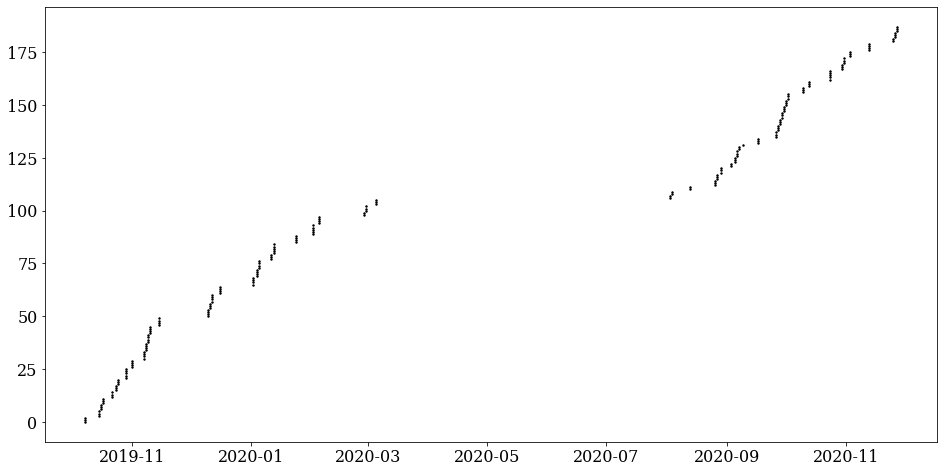

In [8]:
filenames = get_all_spectra_filenames()
dates = get_spectra_dates(filenames)
print(len(dates))

plt.figure(figsize=(16, 8))
for index, date in enumerate(dates):
    year, month, date = date
    d = datetime(year, month, date)
    plt.scatter(d, index, color="k", s=2)


# # Plot files for unique dates
# filenames = get_spectra_filenames_without_duplicate_dates()
# dates = get_spectra_dates(filenames)
# print(len(dates))

# for index, date in enumerate(dates):
#     year, month, date = date
#     d = datetime(year, month, date)
#     plt.scatter(d, index, color="red", s=5)

### First look at data

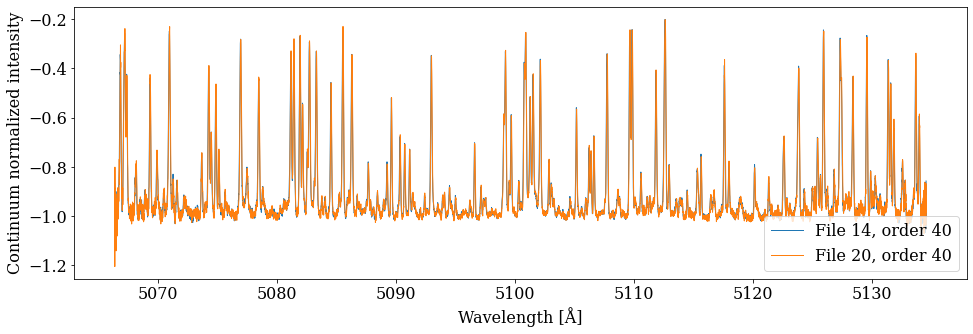

In [41]:
filenames = get_all_spectra_filenames()

def plot_file(file_index, date=None):
    SPECTRA_DATA = load_spectra_fits(filenames[file_index])
    order = 40
    data_spec       = -SPECTRA_DATA['spectrum'][order] # TODO it is more aligned when I add a minus in front, but don't know why??
    data_wavel      = SPECTRA_DATA['wavelength'][order]
    data_continuum  = SPECTRA_DATA['continuum'][order]
    # data_spec_norm = data_spec/np.nanmax(data_spec) # normalize intensity
    data_spec_norm = data_spec/data_continuum # normalize intensity
    
    if date:
        plt.plot(data_wavel, data_spec_norm, linewidth=1, label=f"File {file_index}, order {order}, {date}")
    else:
        plt.plot(data_wavel, data_spec_norm, linewidth=1, label=f"File {file_index}, order {order}")

fig = plt.figure(figsize=(16,5))
plot_file(14)
plot_file(20)
# plt.xlim(5070, 5074)
# plt.xlim(5100, 5500)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Continuum normalized intensity")
plt.legend(loc = "lower right")


### Animate change of peaks over all files



In [78]:
# from tqdm import tqdm

# dates = get_spectra_dates(filenames)
# for i in tqdm(range(len(filenames))):
#     fig = plt.figure(figsize=(16,5))
#     plot_file(0, dates[0])
#     plot_file(i, dates[i])
#     # plt.xlim(5150, 5400)
#     plt.xlim(5077, 5081)
#     plt.ylim(1, 6)
#     plt.xlabel("Wavelength [Å]")
#     plt.ylabel("Intensity")
#     plt.legend(loc = "lower right")
#     plt.grid()
#     plt.savefig(f"figures/shift_wavel_dates/file_{i}.png", dpi=100, facecolor="white")
#     plt.close(fig) # don't show figure

100%|██████████| 188/188 [01:27<00:00,  2.14it/s]


### Interpolation

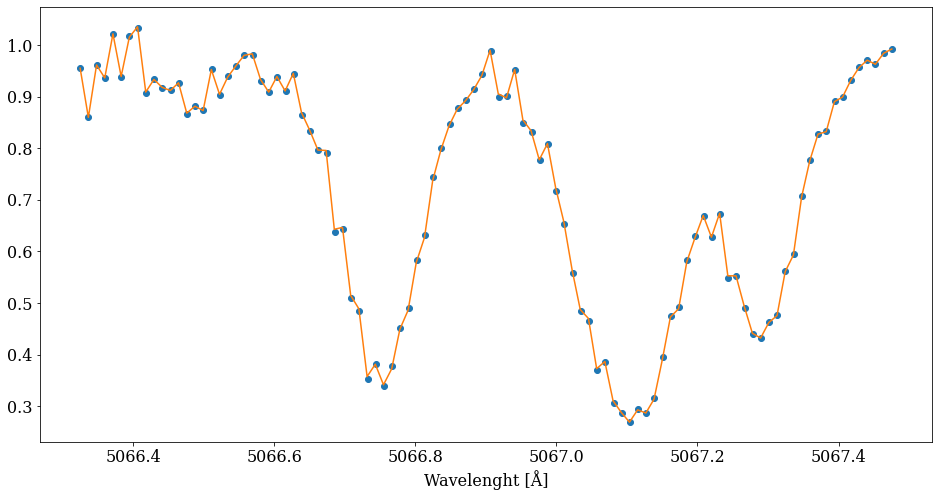

In [21]:
filenames = get_all_spectra_filenames()
filename1 = filenames[0]
filename2 = filenames[1]
order = 40

y1, y1_err, x1 = get_spec_wavel(load_spectra_fits(filename1), order, continuum_normalized=True, angstrom=True)
y2, y2_err, x2 = get_spec_wavel(load_spectra_fits(filename2), order, continuum_normalized=True, angstrom=True)

# Start when data is not nan
x1 = x1[y1 > 0]
y1_err = y1_err[y1 > 0]
y1 = y1[y1 > 0]
x2 = x2[y2 > 0]
y2_err = y2_err[y2 > 0]
y2 = y2[y2 > 0]

# Make plot for the first 100 points
a = x1[0:100]
b = y1[0:100]

plt.figure(figsize=(16,8))
plt.plot(a, b, "o")
plt.xlabel("Wavelenght [Å]")
f1 = interp1d(a, b, kind='cubic')
xnew = np.linspace(min(a), max(a), 100)
plt.plot(xnew, f1(xnew))

### Minimisation with minuit

In [32]:
def interp(x, y):
    return interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)

def compute_shift_between_files_minuit(filename1, filename2, order=40, plot=False):
    y1, y1_err, x1 = get_spec_wavel(load_spectra_fits(filename1), order, continuum_normalized=True, angstrom=True)
    y2, y2_err, x2 = get_spec_wavel(load_spectra_fits(filename2), order, continuum_normalized=True, angstrom=True)

    # Add shift for self test 
    # x2 = x2 + 0.25
    
    # Start when data is not nan
    x1 = x1[y1 > 0]
    y1_err = y1_err[y1 > 0]
    y1 = y1[y1 > 0]
    x2 = x2[y2 > 0]
    y2_err = y2_err[y2 > 0]
    y2 = y2[y2 > 0]

    # Make plot for the first 100 points
    # a = x1[0:100]
    # b = y1[0:100]
    # plt.figure(figsize=(16,8))
    # plt.plot(a, b, "o")
    # f1 = interp1d(a, b, kind='cubic')
    # xnew = np.linspace(min(a), max(a), 100)
    # plt.plot(xnew, f1(xnew))

    # Plot all
    if plot:
        fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,7))
        ax1.plot(x1, y1)
        ax1.plot(x2, y2)

    # Interp first file
    f1 = interp1d(x1, y1, kind='cubic', fill_value="extrapolate")
    f1_upper_err = interp1d(x1, y1 + y1_err, kind='cubic', fill_value="extrapolate")
    f1_lower_err = interp1d(x1, y1 - y1_err, kind='cubic', fill_value="extrapolate")

    # ChiSquare fit model:
    def model_chi2(A):

        # Interpolate template
        interp_x2 = x2 + A
        f2 = interp1d(interp_x2, y2, kind='cubic', fill_value="extrapolate")

        # Find common x-range
        xmin = max([min(x1), min(interp_x2)])
        xmax = min([max(x1), max(interp_x2)])
        xnewCommon = np.linspace(xmin, xmax, 1000)
        
        # Evaluate interpolation
        ynew1 = f1(xnewCommon)
        ynew2 = f2(xnewCommon)

        # Evalute error interpolation
        ynew1_upper_err = f1_upper_err(xnewCommon)
        ynew1_lower_err = f1_lower_err(xnewCommon)
        ynew1_errs = [np.abs(ynew1 - ynew1_upper_err), np.abs(ynew1 - ynew1_lower_err)] 
        ynew1_err = np.mean(ynew1_errs)

        # Compute chi2
        chi2 = np.sum(((ynew1 - ynew2) / ynew1_err)**2)
        return chi2

    model_chi2.errordef = 1

    # First rough minimisation
    shifts = np.linspace(-0.1, 0.1, 500)
    shifts = np.linspace(-10, 10, 500)
    chi2s = []
    for shift in shifts:
        chi2s.append(model_chi2(shift))

    if plot:
        ax1.set_xlabel("Wavenlength [Å]")
        ax1.set_ylabel("Continuum normalized intensity")
        ax2.set_title("Init minimisation")
        ax2.plot(shifts, chi2s)
        ax2.set_xlabel("Wavelength shift [Å]")
        ax2.set_ylabel("Chi2")

    # get shift for minimum chi2
    shift_min = shifts[np.argmin(chi2s)]

    # Now we can use this as init value for iminuit and minimize again
    minuit = Minuit(model_chi2, A=shift_min)
    minuit.migrad()

    # Results
    valid = minuit.valid
    shift_min_final = minuit.values['A']
    shift_min_final_err = minuit.errors['A']

    return shift_min_final, shift_min_final_err, valid


def compute_shift_between_files_minuit_for_orders(filename1, filename2, orders=(37, 85), plot=False):
    shift_min_final, shift_min_final_err, valid = [], [], []
    order_range = np.arange(orders[0], orders[1])
    for order in order_range:
        a, b, c = compute_shift_between_files_minuit(filename1, filename2, plot=plot, order=order)
        shift_min_final.append(a)
        shift_min_final_err.append(b)
        valid.append(c)

    # Convert to numpy
    valid = np.asarray(valid)
    shift_min_final = np.asarray(shift_min_final)
    shift_min_final_err = np.asarray(shift_min_final_err)

    # compute weighted mean
    mean, err = weighted_mean(shift_min_final[valid], shift_min_final_err[valid])

    return mean, err, valid, shift_min_final, shift_min_final_err, order_range

-0.00123, ± 7.8e-05


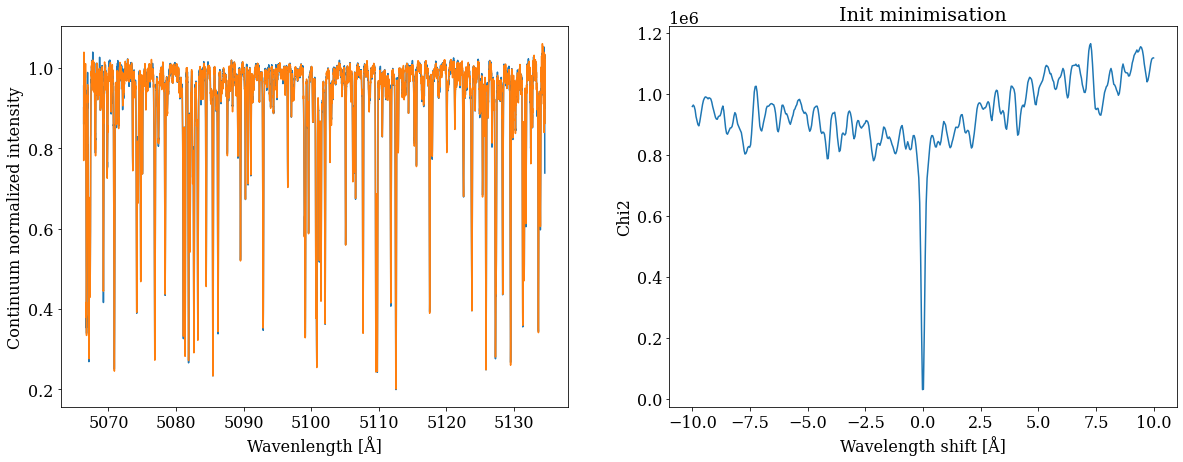

In [33]:
filenames = get_all_spectra_filenames()
r = compute_shift_between_files_minuit(filenames[0], filenames[1], order=40, plot=True)
print(f"{r[0]:.3}, ± {r[1]:.3}")

#### Try out for every order

In [34]:
filenames = get_all_spectra_filenames()
shift_mean, shift_mean_err, valid, shift_min_final, shift_min_final_err, orders = compute_shift_between_files_minuit_for_orders(filenames[0], filenames[1], plot=False)

Text(0.05, 0.93, 'mean shift = (-9.5e-07 ± 2e-07) Å')

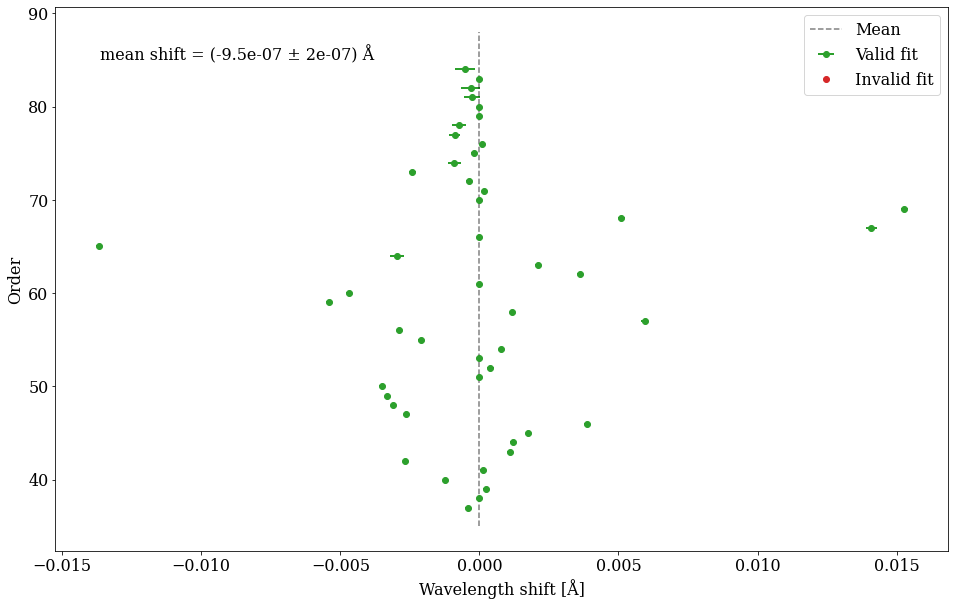

In [35]:
fig, ax = plt.subplots(figsize=(16, 10))

results_valid   = shift_min_final[valid], shift_min_final_err[valid], orders[valid]
results_invalid = shift_min_final[valid==False], shift_min_final_err[valid==False], orders[valid==False]

ax.errorbar(results_valid[0], results_valid[2], xerr=results_valid[1], fmt="o", linewidth=2, color = "C2", label="Valid fit")
ax.errorbar(results_invalid[0], results_invalid[2], fmt="o", linewidth=2, color = "C3", label="Invalid fit") # don't include errs for invalid, too big

# Plot mean and err
ax.vlines(shift_mean, 35, 88, linestyle="dashed", alpha=0.5, color="black", label="Mean")
# ax.axvspan(mean-err, mean+err, alpha=0.2) # too small to see anyway

ax.legend()
ax.set_xlabel("Wavelength shift [Å]")
ax.set_ylabel("Order")

ax.text(0.05, 0.93, f'mean shift = ({shift_mean:.3} ± {shift_mean_err:.1}) Å',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

### The matrix





In [90]:
# # filenames = get_all_spectra_filenames()[:10]
# filenames = get_spectra_filenames_without_duplicate_dates()[:10]
# size = len(filenames)
# diff_matrix, diff_matrix_err = np.empty((size,size)), np.empty((size,size))
# diff_matrix[:], diff_matrix_err[:] = np.nan, np.nan

# # for x in tqdm.tqdm(np.arange(size)):
# for x in tqdm.tqdm(np.arange(size)):
#     for y in np.arange(x, size):
#         shift_min_final, shift_min_final_err, valid = compute_shift_between_files_minuit(filenames[x], filenames[y])
#         if valid:
#             diff_matrix[x, y] = shift_min_final
#             diff_matrix_err[x, y] = shift_min_final_err

100%|██████████| 10/10 [01:11<00:00,  7.14s/it]


In [348]:
# Try with the one for all orders
filenames = get_spectra_filenames_without_duplicate_dates()[:30]
size = len(filenames)
diff_matrix, diff_matrix_err, diff_matrix_valid = np.empty((size,size)), np.empty((size,size)), np.empty((size,size))
diff_matrix[:], diff_matrix_err[:], diff_matrix_valid[:] = np.nan, np.nan, np.nan

for x in tqdm.tqdm(np.arange(size)):
    for y in np.arange(x, size):
        shift_mean, shift_mean_err, valid, *_ = compute_shift_between_files_minuit_for_orders(filenames[x], filenames[y], orders=(37, 85))

        # valid is a list of bools for each order, so extrac the ratio that converged
        valid_ratio = len(valid[valid])/len(valid)

        diff_matrix[x, y] = shift_mean
        diff_matrix_err[x, y] = shift_mean_err
        diff_matrix_valid[x, y] = valid_ratio


# Save
# np.save("lily_data_results/diff", diff_matrix)
# np.save("lily_data_results/diff_err", diff_matrix_err)
# np.save("lily_data_results/diff_valid", diff_matrix_valid)

100%|██████████| 30/30 [5:33:35<00:00, 667.17s/it]  


In [775]:
# Time to exectue matrix: one loop through takes 60 seconds for all orders
n = 58
time_per_file = 2.5 # 2.5 minutes
computations = n * (n + 1) / 2
total_time = time_per_file * computations

print(computations, "computations")
print(f"{(total_time/60):.1f} hours")

# For 30x30 it says 7.75h but it only took 5.5h. 

computations * 1800

1711.0 computations
71.3 hours


3079800.0

In [99]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def plot_matrix(diff_matrix, diff_matrix_err, diff_matrix_valid):

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,10))

    def fix_grid_lines(ax, size):
        ax.hlines(y=np.arange(0, size)+0.5, xmin=np.full(size, 0)-0.5, xmax=np.full(size, size)-0.5, color="black", alpha=0.2)
        ax.vlines(x=np.arange(0, size)+0.5, ymin=np.full(size, 0)-0.5, ymax=np.full(size, size)-0.5, color="black", alpha=0.2)


    # ======= PLOT 1 ============ Mean shifts
    cs = ax1.imshow(-diff_matrix)
    cax = make_axes_locatable(ax1).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
    cbar = fig.colorbar(cs, ax=ax1, cax=cax)
    fix_grid_lines(ax1, len(diff_matrix))

    # ======= PLOT 2 ============ Errors
    cs = ax2.imshow(diff_matrix_err)
    cax = make_axes_locatable(ax2).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
    cbar = fig.colorbar(cs, ax=ax2, cax=cax)
    fix_grid_lines(ax2, len(diff_matrix_err))

    # ======= PLOT 3 ============ Convergence ratio
    cs = ax3.imshow(diff_matrix_valid)
    cax = make_axes_locatable(ax3).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
    cbar = fig.colorbar(cs, ax=ax3, cax=cax)
    # cs.clim(0,1)
    fix_grid_lines(ax3, len(diff_matrix_valid))


    # Fix spacing between plots
    # fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    fig.subplots_adjust(wspace=0.25)

    ax1.set_title("Shift factor")
    ax2.set_title("Error")
    ax3.set_title("Convergence ratio")

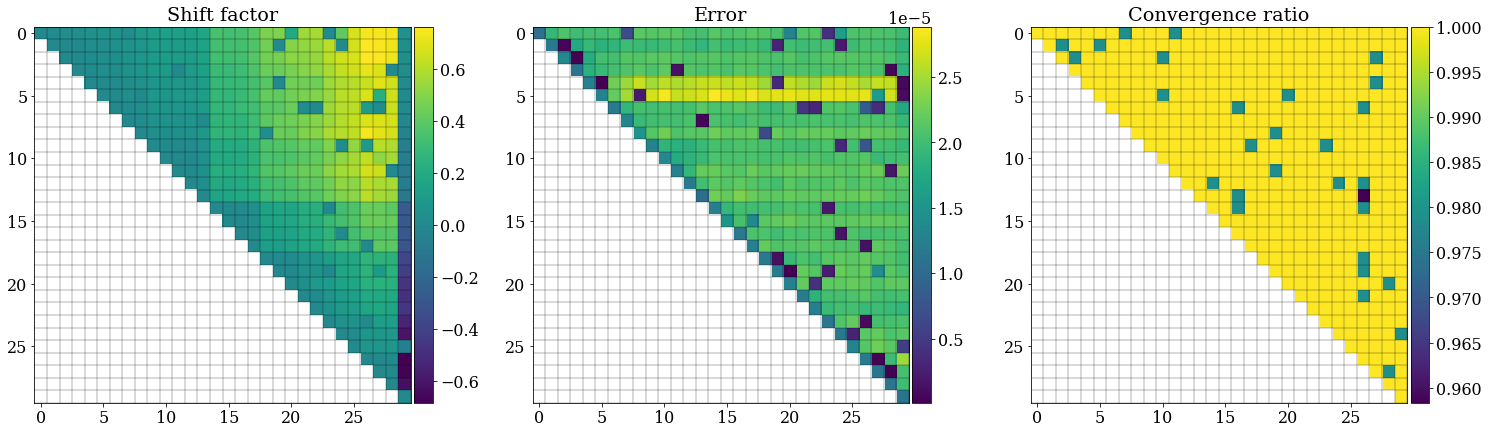

In [230]:
# # Load data again from file
diff_matrix = np.load("lily_data_results/30x30_all_orders_diff.npy")
diff_matrix_err = np.load("lily_data_results/30x30_all_orders_diff_err.npy")
diff_matrix_valid = np.load("lily_data_results/30x30_all_orders_diff_valid.npy")

plot_matrix(diff_matrix, diff_matrix_err, diff_matrix_valid)

### Feature approach

In [47]:

def find_features(filename, plot_orders = None, plot_features_in_order = None, log=True):

    # Filtering parameters
    max_frac_err        = 0.1       # maximum fractional error in intensity
    min_order_goodness  = 0.7       # Min fraction of data in an order that should be left after filtering for the order to be included. 
    min_peak_dist       = 50        # minimum distance (in pixels) between peaks  
    min_peak_prominence = 0.25      # minimum height of peak from base (not zero)
    
    all_peaks = []
    all_feature_slices = []
    feature_slices = []

    fits_data = load_spectra_fits(filename)
    orders_n = shape(fits_data["spectrum"])[0]

    orders = np.arange(0, orders_n)
    for order in orders:
        
        pixel_mask  = fits_data['pixel_mask'][order]    # filter by pixel mask
        y           = fits_data['spectrum'][order][pixel_mask]
        og_y        = y # copy of original y data before filtering
        y_err       = fits_data['uncertainty'][order][pixel_mask]
        continuum   = fits_data['continuum'][order][pixel_mask]
        x           = fits_data['wavelength'][order][pixel_mask]
    
        # Normalize intensity by continuum 
        y = y/continuum
        y_err = y_err/continuum

        # Convert angstorm to cm/s
        x = angstrom_to_velocity(x)

        # filter by fractional error 
        frac_err = y_err/y
        frac_err_mask = (0 < frac_err) & (frac_err < max_frac_err) # reject if larger than 10% and negative
        y = y[frac_err_mask]
        y_err = y_err[frac_err_mask]
        x = x[frac_err_mask]

        # Skip order if we filtered out more than 1 - min_order_goodness of the data (bad order ... )
        if len(y) / len(og_y) < min_order_goodness:
            all_feature_slices.append(np.nan)
            continue

        # Now invert peaks
        y = 1 - y

        peaks = func_find_peaks(y, min_peak_dist, min_peak_prominence)
        peak_locs = peaks[0]
        peak_height = peaks[5] # peak height from y=0 
        all_peaks.append(peak_locs)

        # Plot
        if plot_orders is not None and (plot_orders == order).any():
            plt.figure(figsize=(30,3))
            plt.plot(x, y, ".")
            plt.plot(x[peak_locs], peak_height, "o", color="C3", label=f"{order}. order")
            plt.ylabel("1 - Continuum normalized counts")
            plt.xlabel("Wavelength [Å]")
            plt.legend(loc = "upper right")
            
            # plt.figure(figsize=(30,1))
            # plt.plot(x_gone, frac_err[frac_err_mask == False], color="red")
            # plt.xlabel("Wavelength [Å]")

        # If less than 10 peaks skip order
        if len(peak_locs) < 5:
            # all_feature_slices.append([np.nan, order])
            all_feature_slices.append(np.nan)
            continue

        peak_index_ranges = get_peak_index_ranges(peak_locs, peak_range_size=50)

        # feature_slices = []
        for index, range in enumerate(peak_index_ranges):
            start, end = range

            if len(x[start:end]) != 0 and len(y[start:end]) != 0: # sometimes these lists come out empty. 
                feature_slices.append([x[start:end], y[start:end], y_err[start:end], x[peak_locs[index]], peak_locs[index], order])

            if plot_features_in_order is not None and (plot_features_in_order == order).any():
                plt.figure(figsize=(10,3))
                plt.plot(x[start:end], y[start:end], ".")
                plt.plot(x[peak_locs[index]], peak_height[index], "o", color="C3", label=f"$k = {index}$")
                plt.legend(loc = "upper right")
        
        # all_feature_slices.append([feature_slices, order])
        all_feature_slices.append(feature_slices)

    all_peaks = np.concatenate(all_peaks)
    if log:
        print(len(all_peaks), "peaks found")

    # return np.asarray(all_feature_slices, dtype=object)
    return np.asarray(feature_slices, dtype=object)

In [244]:
# Plot all orders in one file
# filenames = get_spectra_filenames_without_duplicate_dates()[:30]
# d1 = find_features(filenames[0], plot_orders = np.arange(0, 86))

2813 peaks found
2970 peaks found


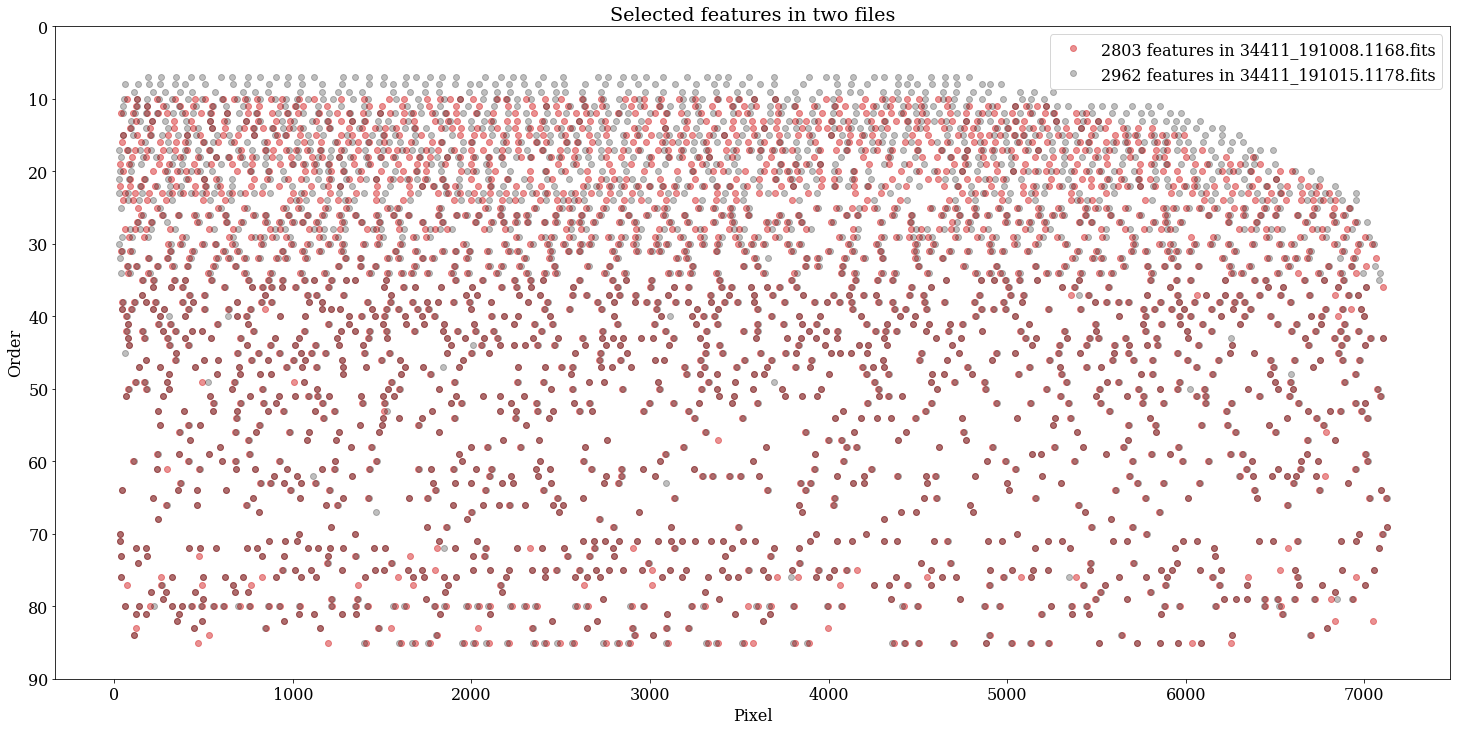

In [43]:
filenames = get_spectra_filenames_without_duplicate_dates()
file1, file2 = filenames[0], filenames[1]
d1 = find_features(file1)
d2 = find_features(file2)

plt.figure(figsize=(25,12))
plt.title(f"Selected features in two files")
x1, y1, x2, y2 = d1[:, 4], d1[:, 5], d2[:, 4], d2[:, 5]
plt.plot(x1, y1, "o", label=f"{len(d1)} features in {file1}", alpha=0.5, color="C3")
plt.plot(x2, y2, "o", label=f"{len(d2)} features in {file2}", alpha=0.25, color="k")
plt.xlabel("Pixel")
plt.ylabel("Order")
plt.ylim(0, 90)
plt.gca().invert_yaxis()
plt.legend()

#### Now we need to find a way to match peaks

In [513]:
def find_feature_matches(features1, features2, log=True, filter=True, relative_tolerance=0.0008, absolute_tolerance=5):
    """ Finds features in two files, and iterates from the lowest wavelength to the highest, in small
        steps, asking if either of the files have features close to the current wavelength within a
        defined tolerance. If so, it returns a match. 
    """

    peaks1 = np.array(features1[:, 3], dtype=float)
    peaks2 = np.array(features2[:, 3], dtype=float)

    max1, max2 = np.max(peaks1), np.max(peaks2)
    min1, min2 = np.min(peaks1), np.min(peaks2)

    common_max = min([max1, max2])
    common_min = max([min1, min2])

    # We should of course only use each peak once, so let's keep track of the peaks we use
    used_peaks1 = np.asarray([False] * len(peaks1))
    used_peaks2 = np.asarray([False] * len(peaks2))

    range = np.linspace(common_min, common_max, 10000)
    # relative_tolerance = 0.0001 # lower value --> fewer matches, higher --> worse matches # but first we set a high value and then filter later
    # relative_tolerance = 0.00005 # lower value --> fewer matches, higher --> worse matches
    # relative_tolerance = 0.001 # lower value --> fewer matches, higher --> worse matches
    # relative_tolerance = 0.00002 # lower value --> fewer matches, higher --> worse matches
    
    matches = []
    for wavel in range:
        
        # see if we have a match in the two lists:
        match_mask1 = np.isclose(peaks1, wavel, relative_tolerance)
        match_mask2 = np.isclose(peaks2, wavel, relative_tolerance)
        
        # Only take match if we have only one match from each file
        if len(match_mask1[match_mask1]) == 1 and len(match_mask2[match_mask2]) == 1:

            # get the two features that matched
            f1 = features1[match_mask1][0]
            f2 = features2[match_mask2][0]

            # Now perform a bit of filtering: 
            if filter:

                # Check if the sum of the y values are about equal, if so it means we probably have the same peak.
                f1_spec, f2_spec = f1[1], f2[1]
                if np.isclose(np.sum(f1_spec), np.sum(f2_spec), 0.1) == False:
                    continue

                # If the difference bewteen the two peaks is larger than 5 cm/s pass it
                f1_peak, f2_peak = f1[3], f2[3]
                if abs(f1_peak - f2_peak) > 5:
                    continue
                    
            # Get the index of the peak
            used_peak_index2 = np.where(match_mask2)[0]
            used_peak_index1 = np.where(match_mask1)[0]

            # Append if we have not already used this peak
            if used_peaks1[used_peak_index1] == False and used_peaks2[used_peak_index2] == False:
                
                # Append
                matches.append([f1, f2])

                # Mark that we used the peaks
                used_peaks1[used_peak_index1] = True
                used_peaks2[used_peak_index2] = True
            
    if log:
        print(f"{len(matches)} matches found")
    
    return matches

filenames = get_spectra_filenames_without_duplicate_dates()

_ = find_feature_matches(find_features(filenames[0]), find_features(filenames[1]), relative_tolerance=0.0008)

2813 peaks found
2970 peaks found
113 matches found


#### Plot number of matches a function of tolerance

In [355]:
filenames = get_spectra_filenames_without_duplicate_dates()
file1, file2 = filenames[0], filenames[10]

tolerances = np.linspace(0.00001, 0.001, 50)

num_matches = []
for tol in tolerances:
    matches = find_feature_matches(find_features(file1, log=False), find_features(file2, log=False), filter=True, log=False, relative_tolerance=tol)
    num_matches.append(len(matches))

Text(0.5, 0, 'Relative tolerance')

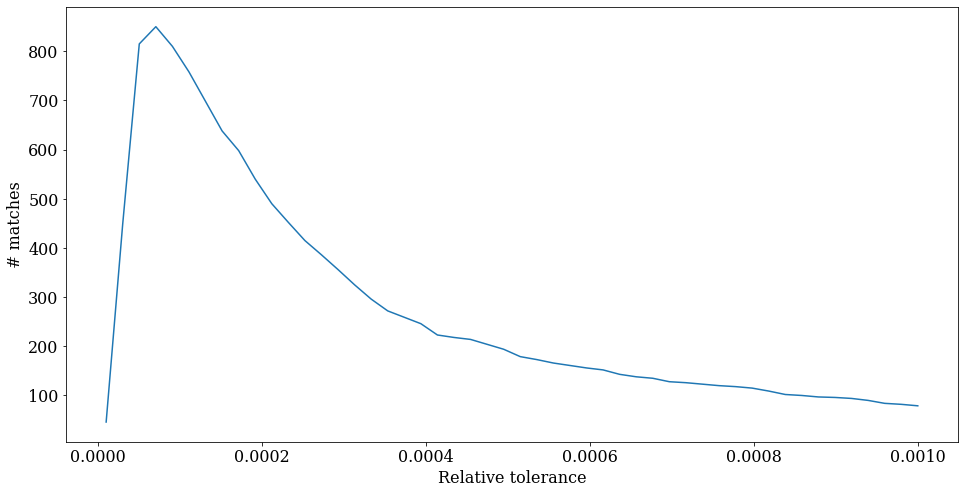

In [357]:
plt.figure(figsize=(16,8))
plt.plot(tolerances, num_matches)
plt.ylabel("# matches")
plt.xlabel("Relative tolerance")

100%|██████████| 9/9 [01:14<00:00,  8.28s/it]


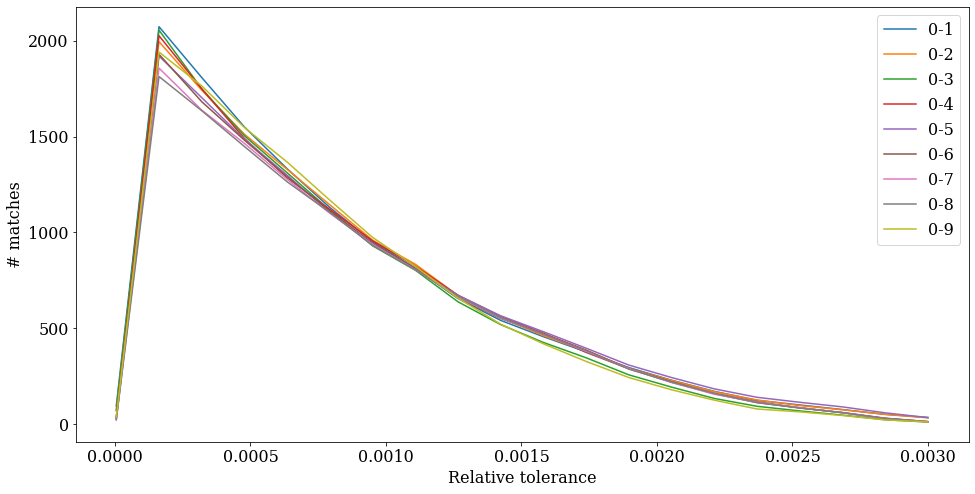

In [95]:
# Compare with many files:

plt.figure(figsize=(16,8))
plt.ylabel("# matches")
plt.xlabel("Relative tolerance")
tolerances = np.linspace(0.000005, 0.003, 20)
filenames = get_spectra_filenames_without_duplicate_dates()

file1 = filenames[0]
f1 = find_features(file1, log=False)

for i in tqdm(np.arange(1, 10)):
    file2 = filenames[i]
    num_matches = []
    for tol in tolerances:
        matches = find_feature_matches(f1, find_features(file2, log=False), filter=True, log=False, relative_tolerance=tol)
        num_matches.append(len(matches))
    plt.plot(tolerances, num_matches, label=f"0-{i}")

plt.legend()

In [110]:
# Plot a matrix of number of returned matches for a given tolerance

filenames = get_spectra_filenames_without_duplicate_dates()
size = len(filenames)
match_matrix, match_matrix_err, match_matrix_valid = np.empty((size,size)), np.empty((size,size)), np.empty((size,size))
match_matrix[:], match_matrix_err[:], match_matrix_valid[:] = np.nan, np.nan, np.nan

# It takes 15 seconds to find features in all files
features = [find_features(filename, log=False) for filename in filenames]

for x in tqdm(np.arange(size)):
    for y in np.arange(x, size):
        
        matches = find_feature_matches(features[x], features[y], log=False, relative_tolerance=0.0009)
        match_matrix[x, y] = len(matches)

        # match_matrix_err[x, y] = shift_mean_err
        # match_matrix_valid[x, y] = valid_ratio


100%|██████████| 58/58 [09:10<00:00,  9.49s/it]


Text(0.5, 1.0, 'Number of matches for relative tolerance = 0.0009')

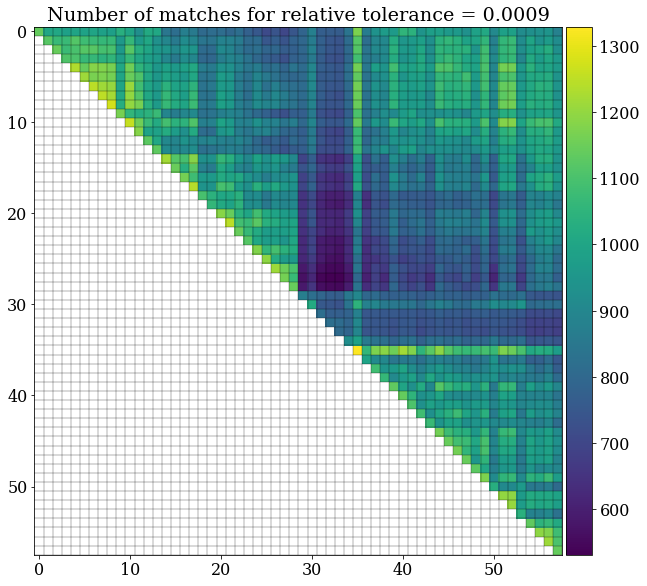

In [116]:
# plot_matrix(match_matrix, match_matrix_err, match_matrix_valid)

# fig, ax = plt.subplots(figsize=(15, 15))
# ax.matshow(match_matrix)


from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# def plot_matrix(diff_matrix, diff_matrix_err, diff_matrix_valid):

fig, ax1 = plt.subplots(figsize=(10,10))

def fix_grid_lines(ax, size):
    ax.hlines(y=np.arange(0, size)+0.5, xmin=np.full(size, 0)-0.5, xmax=np.full(size, size)-0.5, color="black", alpha=0.2)
    ax.vlines(x=np.arange(0, size)+0.5, ymin=np.full(size, 0)-0.5, ymax=np.full(size, size)-0.5, color="black", alpha=0.2)

cs = ax1.imshow(match_matrix)
cax = make_axes_locatable(ax1).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
cbar = fig.colorbar(cs, ax=ax1, cax=cax)
fix_grid_lines(ax1, len(match_matrix))

ax1.set_title("Number of matches for relative tolerance = 0.0009")


#### Illustrate the match selection

In [494]:
def plot_matches(matches):

    height = 1
    while height * 10 < len(matches):
        height += 1


    assert height < 100, "Height is higher than 100"

    # Plot matches
    fig, axs = plt.subplots(nrows=height, ncols=10, figsize=(10 * 2.5, height * 2))
    for k in np.arange(len(matches)):
        f1 = matches[k][0]
        f2 = matches[k][1]

        if k > len(axs.flat):
            break

        ax = axs.flat[k]

        wavel1 = f1[0]
        spec1 = f1[1]
        peak1 = f1[3]
        wavel2 = f2[0]
        spec2 = f2[1]
        peak2 = f2[3]

        # Plot difference
        # ax.plot(wavel1, spec1-spec2, color="k")

        # Plot
        ax.plot(wavel1, spec1, color="C0")
        ax.vlines(peak1, 0, 1, linestyle="dashed", color="C0")
        ax.plot(wavel2, spec2, color="C3")
        ax.vlines(peak2, 0, 1, linestyle="dashed", color="C3")

        # Plot peak difference
        diff = peak1 - peak2
        diff = np.round(diff, 3)
        ax.text(0.25, 0.8, diff, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

        if np.isclose(np.sum(spec1), np.sum(spec2), 0.1):
            ax.set_facecolor('honeydew')


    # Remove ticks
    for ax in axs.flat:
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])

In [496]:
# TO DELETE

# Investigate specific mis matched peak

# filenames = get_spectra_filenames_without_duplicate_dates()
# file1, file2 = filenames[12], filenames[15]
# matches = find_feature_matches(find_features(file1), find_features(file2), filter=True)
# shifts = compute_all_feature_shifts([matches[56]])

# k = 56

# f1 = matches[k][0]
# f2 = matches[k][1]
# x1 = f1[0]
# y1 = f1[1]
# peak1 = f1[3]
# x2 = f2[0]
# y2 = f2[1]
# peak2 = f2[3]

# plt.figure(figsize=(15,8))
# plt.plot(x1, y1)
# plt.plot(x2, y2)
# # plt.plot(x1 + shifts[0][0], y1)

# np.sum(y1), np.sum(y2), np.mean(y1), np.mean(y2)

2852 peaks found
2890 peaks found
114 matches found


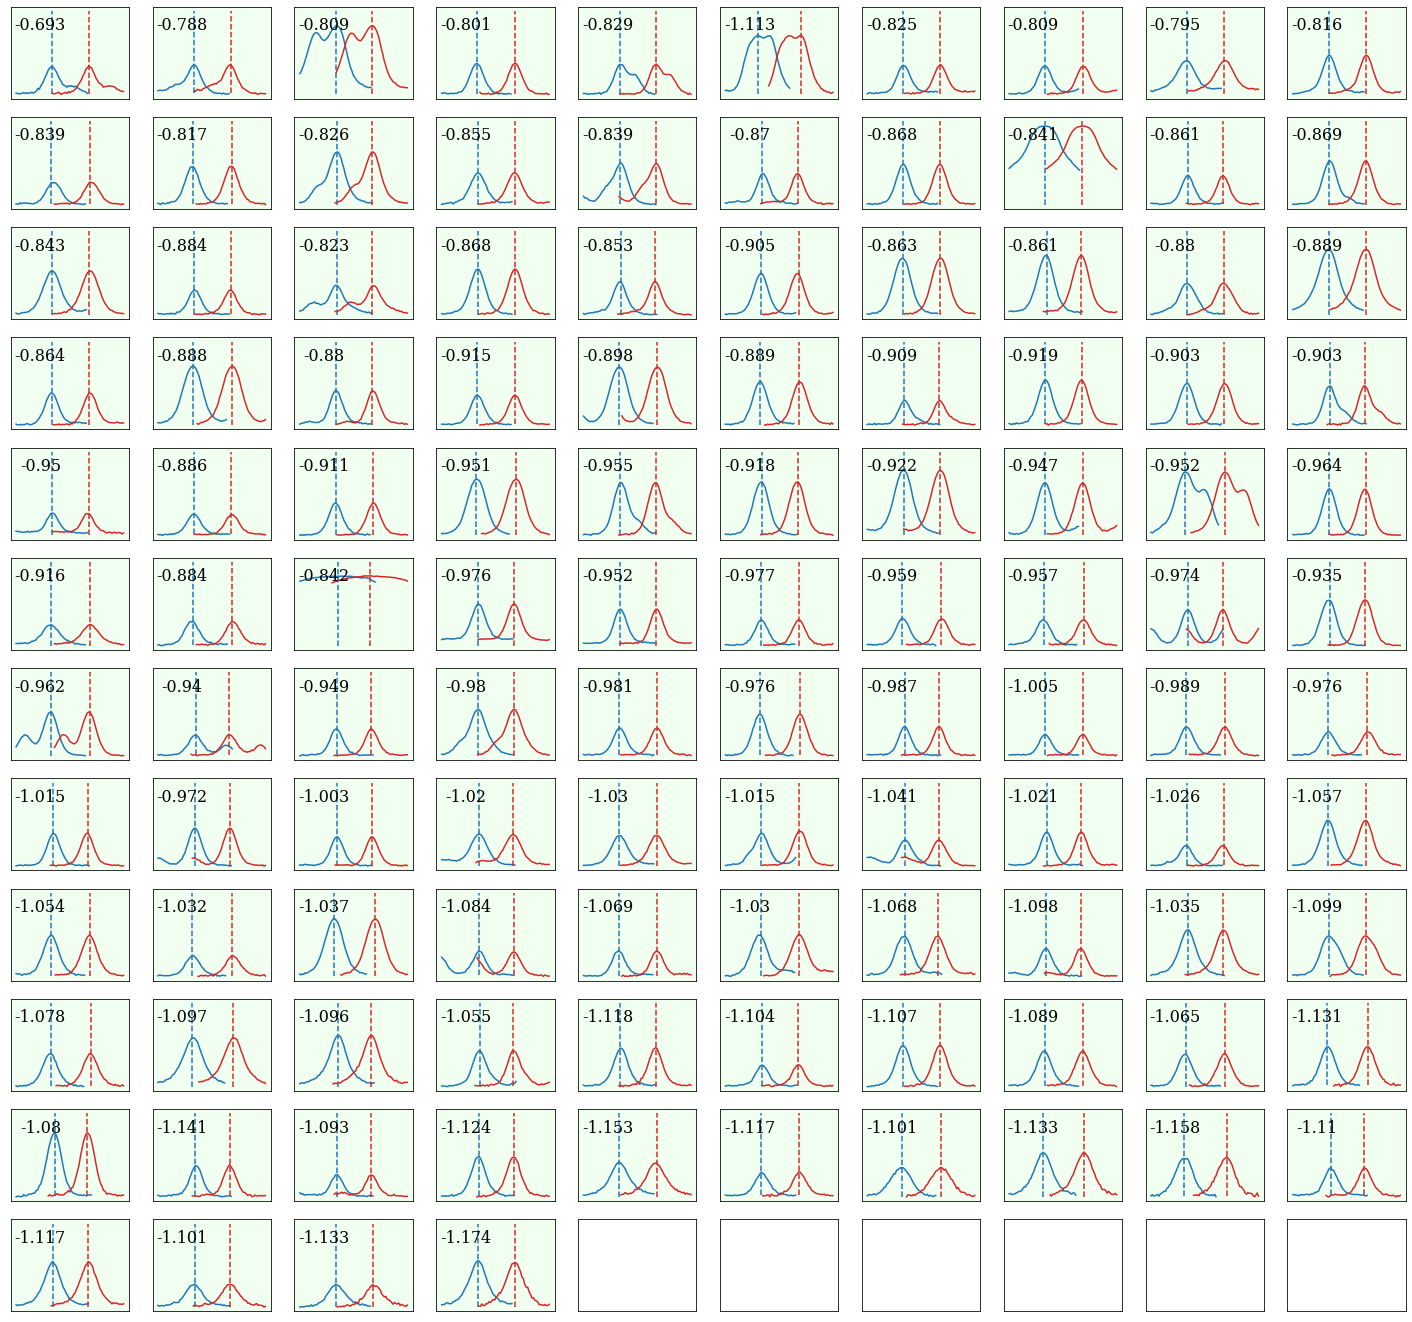

In [514]:
filenames = get_spectra_filenames_without_duplicate_dates()
file1, file2 = filenames[12], filenames[15]
matches = find_feature_matches(find_features(file1), find_features(file2), filter=True, relative_tolerance=0.0007)
plot_matches(matches)

0 / 114 fits failed


/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


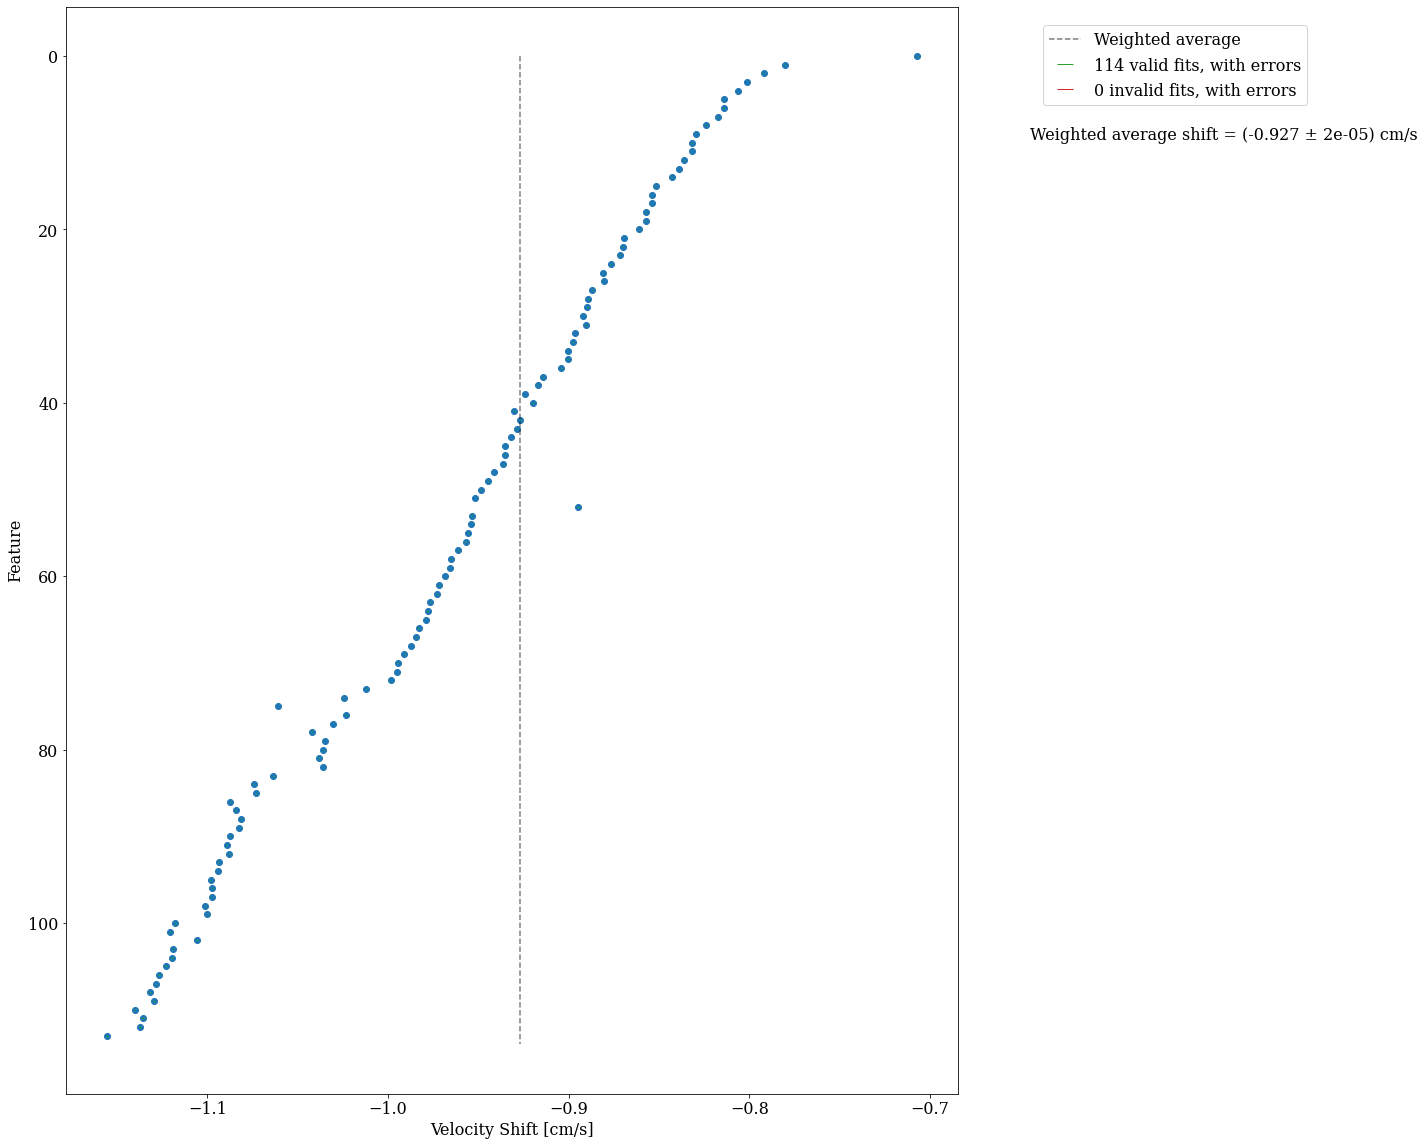

In [516]:
shifts = compute_all_feature_shifts(matches)
plot_features_shift(shifts)

### Do template fitting for features

In [252]:
# def compute_feature_shift(x1, y1, y1_err, x2, y2, plot=False):
# """ Compute shift first with rough estimation and then with iminuit.
#     Turns out the rough estimate fails quite often while iminuit can
#     handle it moooost of the time with init value 0. """
    
#     # Add shift for self test 
#     # x2 = x2 + 0.25
    
#     # Plot all
#     if plot:
#         fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize=(20,7))
        
#         # Plot match
#         ax1.plot(x1, y1)
#         ax1.plot(x2, y2)

#     # Interp first file
#     f1 = interp1d(x1, y1, kind='cubic', fill_value="extrapolate")
#     f1_upper_err = interp1d(x1, y1 + y1_err, kind='cubic', fill_value="extrapolate")
#     f1_lower_err = interp1d(x1, y1 - y1_err, kind='cubic', fill_value="extrapolate")

#     # ChiSquare fit model:
#     def model_chi2(A):

#         # Interpolate template
#         interp_x2 = x2 + A
#         f2 = interp1d(interp_x2, y2, kind='cubic', fill_value="extrapolate")

#         # Find common x-range
#         xmin = max([min(x1), min(interp_x2)])
#         xmax = min([max(x1), max(interp_x2)])
#         xnewCommon = np.linspace(xmin, xmax, 1000)
        
#         # Evaluate interpolation
#         ynew1 = f1(xnewCommon)
#         ynew2 = f2(xnewCommon)

#         # Evalute error interpolation
#         ynew1_upper_err = f1_upper_err(xnewCommon)
#         ynew1_lower_err = f1_lower_err(xnewCommon)
#         ynew1_errs = [np.abs(ynew1 - ynew1_upper_err), np.abs(ynew1 - ynew1_lower_err)] 
#         ynew1_err = np.mean(ynew1_errs)

#         # Compute chi2
#         chi2 = np.sum(((ynew1 - ynew2) / ynew1_err)**2)
#         return chi2
#     model_chi2.errordef = 1

#     # First rough minimisation
#     # shifts = np.linspace(-0.1, 0.1, 500)
#     shifts = np.linspace(-10, 10, 500)
#     shifts = np.linspace(-3, 3, 2000)
#     chi2s = []
#     for shift in shifts:
#         chi2s.append(model_chi2(shift))

#     # get shift for minimum chi2
#     shift_min = shifts[np.argmin(chi2s)]

#     if plot:
#         ax4.set_title("Init minimisation")
#         ax4.plot(shifts, chi2s, label=f"Min = {shift_min:.3}")
#         ax4.set_xlabel("Wavelength shift")
#         ax4.set_ylabel("Chi2")
#         ax4.legend()

#         # Instead plot the shifted values after init minimisation
#         ax2.plot(x1, y1)
#         ax2.plot(x2 + shift_min, y2)
        
#     # Now we can use this as init value for iminuit and minimize again
#     minuit = Minuit(model_chi2, A=shift_min)
#     minuit.migrad()

#     # Results
#     valid = minuit.valid
#     shift_min_final = minuit.values['A']
#     shift_min_final_err = minuit.errors['A']

#     # Plot final shifted values
#     if plot:
#         # Instead plot the shifted values after init minimisation
#         ax3.plot(x1, y1)
#         ax3.plot(x2 + shift_min_final, y2)

#     return shift_min_final, shift_min_final_err, valid

In [471]:
def compute_feature_shift(x1, y1, y1_err, peak1, x2, y2, peak2, plot=False, ax=None):
    
    # Add shift for self test 
    # x2 = x2 + 0.25
    
    # Interp first file
    f1 = interp1d(x1, y1, kind='cubic', fill_value="extrapolate")
    f1_upper_err = interp1d(x1, y1 + y1_err, kind='cubic', fill_value="extrapolate")
    f1_lower_err = interp1d(x1, y1 - y1_err, kind='cubic', fill_value="extrapolate")

    # ChiSquare fit model:
    def model_chi2(A):

        # Interpolate template
        interp_x2 = x2 + A
        f2 = interp1d(interp_x2, y2, kind='cubic', fill_value="extrapolate")

        # Find common x-range
        xmin = max([min(x1), min(interp_x2)])
        xmax = min([max(x1), max(interp_x2)])
        xnewCommon = np.linspace(xmin, xmax, 1000)
        
        # Evaluate interpolation
        ynew1 = f1(xnewCommon)
        ynew2 = f2(xnewCommon)

        # Evalute error interpolation
        ynew1_upper_err = f1_upper_err(xnewCommon)
        ynew1_lower_err = f1_lower_err(xnewCommon)
        ynew1_errs = [np.abs(ynew1 - ynew1_upper_err), np.abs(ynew1 - ynew1_lower_err)] 
        ynew1_err = np.mean(ynew1_errs)

        # Compute chi2
        chi2 = np.sum(((ynew1 - ynew2) / ynew1_err)**2)
        return chi2
    model_chi2.errordef = 1
        
    A_init = peak1 - peak2
    minuit = Minuit(model_chi2, A=A_init)
    minuit.migrad()

    # Results
    valid = minuit.valid
    shift_min_final = minuit.values['A']
    shift_min_final_err = minuit.errors['A']

    # Plot final shifted values
    if plot:

        if ax == None:
            fig, ax = plt.subplots(figsize=(14,6))

        ax.plot(x1, y1)
        ax.plot(x2 + shift_min_final, y2)
        # ax.plot(x1, y2 - y1, "k")
        
        # summed_diff = np.sum(x1 - (x2 + shift_min_final))
        # if summed_diff > diff:
        #     ax.set_facecolor('honeydew')

        if np.isclose(np.sum(y1), np.sum(y2), 0.1):
            ax.set_facecolor('honeydew')


    return shift_min_final, shift_min_final_err, valid, y2 - y1

In [472]:
def compute_all_feature_shifts(matches, log=True, plot=False, ax=[]):

    shifts = []
    # for k in tqdm(np.arange(len(matches))):
    for k in np.arange(len(matches)):
        f1 = matches[k][0]
        f2 = matches[k][1]

        x1      = f1[0]
        y1      = f1[1]
        y1_err  = f1[2]
        peak1   = f1[3]
        x2      = f2[0]
        y2      = f2[1]
        peak2   = f2[3]

        if len(ax) == 0:
            shifts.append(compute_feature_shift(x1, y1, y1_err, peak1, x2, y2, peak2, plot=plot))
        else:
            shifts.append(compute_feature_shift(x1, y1, y1_err, peak1, x2, y2, peak2, plot=plot, ax=ax[k]))


    shifts = np.asarray(shifts)
    if log:
        print(f"{len(shifts[:, 2][shifts[:, 2] == 0])} / {len(shifts)} fits failed")
    return shifts

In [311]:
def plot_features_shift(shifts, ax=None, labels=True):
        s, s_err, s_valid = shifts[:, 0], shifts[:, 1], shifts[:, 2]

        feature_n = np.arange(len(s))
        valid_shifts, valid_shifts_err, valid_features          = s[s_valid == 1], s_err[s_valid == 1], feature_n[s_valid == 1]
        invalid_shifts, invalid_shifts_err, invalid_features    = s[s_valid == 0], s_err[s_valid == 0], feature_n[s_valid == 0]

        if ax == None:
             fig, ax = plt.subplots(figsize=(16, 20))

        # ax.errorbar(valid_shifts, valid_features, xerr=valid_shifts_err * 100, fmt="none", linewidth=1, color = "C2", label=rf'{len(valid_shifts)} valid fits, with errors $\times 100$')
        # ax.errorbar(invalid_shifts, invalid_features, xerr=invalid_shifts_err * 100, fmt="none", linewidth=1, color = "C3", label=rf'{len(invalid_shifts)} invalid fits, with errors $\times 100$')
        ax.errorbar(valid_shifts, valid_features, xerr=valid_shifts_err, fmt="none", linewidth=1, color = "C2", label=rf'{len(valid_shifts)} valid fits, with errors')
        ax.errorbar(invalid_shifts, invalid_features, xerr=invalid_shifts_err, fmt="none", linewidth=1, color = "C3", label=rf'{len(invalid_shifts)} invalid fits, with errors')

        ax.scatter(valid_shifts, valid_features)
        ax.scatter(invalid_shifts, invalid_features)


        shift_mean, shift_mean_err = weighted_mean(valid_shifts, valid_shifts_err)

        # # Plot mean and err
        ax.vlines(shift_mean, 0, len(s), linestyle="dashed", alpha=0.5, color="black", label="Weighted average")
        # ax.axvspan(shift_mean-shift_mean_err, shift_mean+shift_mean_err, alpha=0.2) # too small to see anyway

        # invert axis so feature 0 starts at the top
        plt.gca().invert_yaxis()

        if labels:
                ax.legend(bbox_to_anchor=(1.4, 0.99))
                ax.set_xlabel("Velocity Shift [cm/s]")
                ax.set_ylabel("Feature")
                ax.text(1.08, 0.89, f'Weighted average shift = ({shift_mean:.3} ± {shift_mean_err:.1}) cm/s',
                        horizontalalignment='left',
                        verticalalignment='top',
                        transform=ax.transAxes)
        else:
                # hide ticks
                ax.axes.xaxis.set_ticklabels([])
                ax.axes.yaxis.set_ticklabels([])
                ax.axes.xaxis.set_ticks([])
                ax.axes.yaxis.set_ticks([])


        # fig.savefig("fdsfds.png", dpi=400)

2852 peaks found
2890 peaks found
99 matches found
10


/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


0 / 99 fits failed


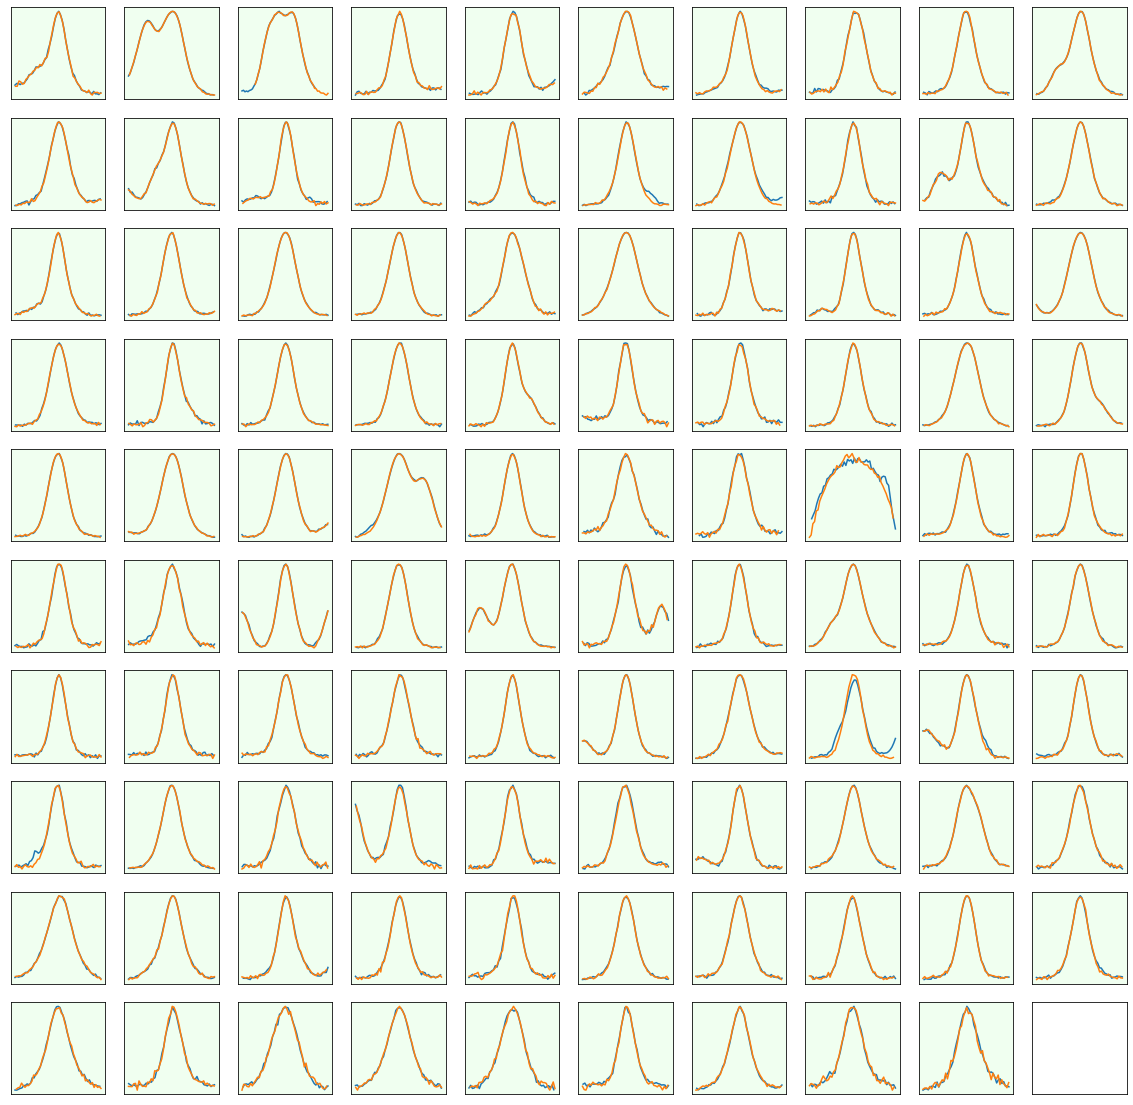

In [518]:
filenames = get_spectra_filenames_without_duplicate_dates()
file1, file2 = filenames[12], filenames[15]
matches = find_feature_matches(find_features(file1), find_features(file2))

# Compute how many rows we need to display all
height = 1
while 10 * height < len(matches):
    height += 1
assert (height < 100), "Height is more than 100"

print(height)

# Compute a plot shifts
fig, axs = plt.subplots(height, 10, figsize=(20, 20))
shifts = compute_all_feature_shifts(matches, plot=True, ax=axs.flat)

# Remove ticks
for ax in axs.flat:
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])


# # Plot shift values
# plot_features_shift(shifts)

In [386]:
# # Filter the larger ones
# df = pd.DataFrame(shifts, copy=True)
# df.columns = ["x", "err", "valid"]
# df.valid[:] = 1 # reset ... 
# df.valid[df.x > 0.2] = 0 
# df.valid[df.x < -0.2] = 0 
# n = np.asarray(df)
# plot_features_shift(n)

### Plot features plot for several files

In [358]:
# filenames = get_spectra_filenames_without_duplicate_dates()
# shifts = []
# for i in np.arange(0, 8):
#     matches = find_feature_matches(find_features(filenames[i]), find_features(filenames[i+1]), log=False)
#     shifts.append(compute_all_feature_shifts(matches, log=False))


# # Plot 
# for s in shifts:
#     plot_features_shift(s)

## The Matrix with features

In [519]:
# Try with the one for all orders
filenames = get_spectra_filenames_without_duplicate_dates()[:10]
size = len(filenames)
diff_matrix, diff_matrix_err, diff_matrix_valid = make_nan_matrix(size), make_nan_matrix(size), make_nan_matrix(size)

# It takes 15 seconds to find features in all files
features = [find_features(filename, log=False) for filename in filenames]

for x in tqdm(np.arange(size)):
    for y in np.arange(x, size):
        
        matches = find_feature_matches(features[x], features[y], log=False)
        shifts = compute_all_feature_shifts(matches[:20], log=False)
        shifts_list, shifts_err_list, shifts_valid_list = shifts[:, 0], shifts[:, 1], shifts[:, 2]

        # Compute weighted average
        shift_mean, shift_mean_err = weighted_mean(shifts_list, shifts_err_list)

        # Compute valid ratio, number of succesfull fits / total number of fits
        valid_ratio = len(shifts_valid_list[shifts_valid_list == 1])/len(shifts_valid_list)

        diff_matrix[x, y] = shift_mean
        diff_matrix_err[x, y] = shift_mean_err
        diff_matrix_valid[x, y] = valid_ratio

100%|██████████| 10/10 [00:23<00:00,  2.40s/it]


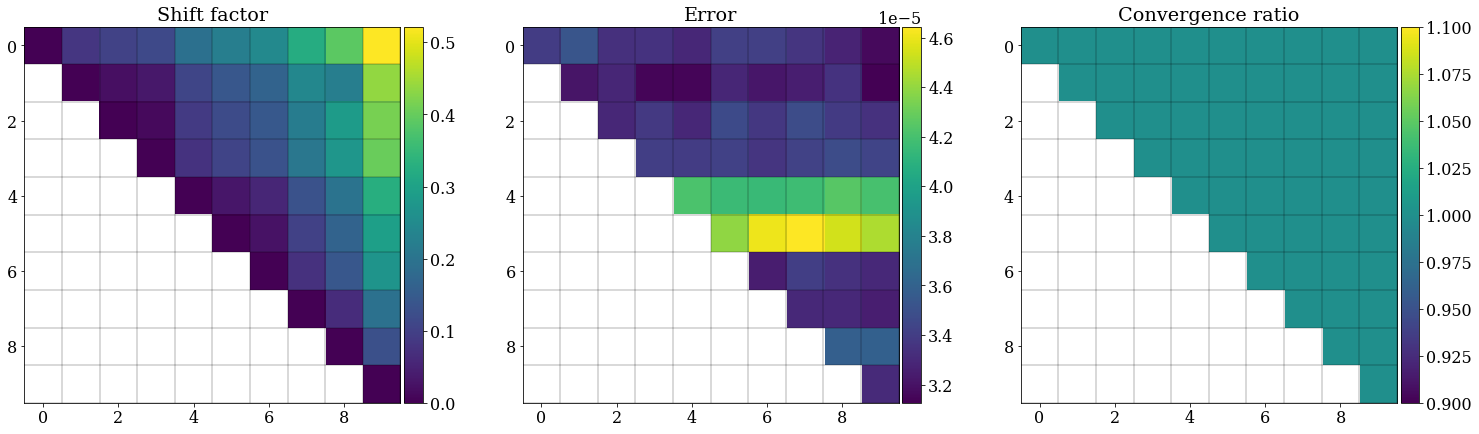

In [520]:
plot_matrix(diff_matrix, diff_matrix_err, diff_matrix_valid)

### Multi-core

In [521]:
import multiprocess
# from os import getpid

N_processes = 6
# N_files = 3
# N_features = 1000

# 43m for 30 files, 5th feature, on 6 processes. 

# 1m20 for 5 files, 5th feature, on 6 processes. 
# 1m25 for 5 files, 5th feature, on 8 processes. (using efficiency cores)
# 1m53 for 5 files, 5th feature, on 4 processes.
# 6m19 for 5 files, 5th feature, on 1 process.
# One core: all files should take ~71 hours --> Six cores: ~ 15 hours, looks more like 11 hours
# Six cores: only took 8 hours

# So 6 cores is (6*60 + 19)/(60 + 20) = 4.73 times faster than one core. 

# Get list of files and find all features
filenames = get_spectra_filenames_without_duplicate_dates()
features = [find_features(filename, log=False) for filename in filenames]

# Setup matrices
size = len(filenames)
diff_matrix, diff_matrix_err, diff_matrix_valid = make_nan_matrix(size), make_nan_matrix(size), make_nan_matrix(size)

# Compute one list of coords
coords = []
for x in np.arange(size):
    for y in np.arange(x, size):
        if x != y:
            coords.append((x, y)) 
        
        
# Define function for each process
def compute_shift_for_coords_chunk(coords):
    x = coords[0]
    y = coords[1]
    matches = find_feature_matches(features[x], features[y], log=False)
    shifts = compute_all_feature_shifts(matches, log=False) # TESTING: ONLY RUNNING SOME FEATURES
    return shifts


if __name__ == '__main__':
    
    pool = multiprocess.Pool(processes = N_processes)
    # result = pool.map(compute_shift_for_coords_chunk, coords)
    
    # With progress bar
    result = []
    for r in tqdm(pool.imap_unordered(compute_shift_for_coords_chunk, coords), total=len(coords)):
        result.append(r)


np.save("lily_data_results/58x58_all_features_fixed2", [result, coords])

100%|██████████| 1653/1653 [03:53<00:00,  7.09it/s]
/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [73]:
# np.save("lily_data_results/30x30_5th_feature", [result, coords])

In [371]:
def filter_results(result, coords):
    
    size = np.max(np.max(coords)) + 1
    diff_matrix, diff_matrix_err, diff_matrix_valid = make_nan_matrix(size), make_nan_matrix(size), make_nan_matrix(size)

    for coord, shifts in zip(coords, result):

        # Compute valid ratio, number of succesfull fits / total number of fits
        valids = shifts[:, 2]
        valid_ratio = len(valids[valids == 1])/len(valids)

        # Filter away larger values by setting valid to zero (false)
        # df = pd.DataFrame(shifts, copy=True)
        # df.columns = ["x", "err", "valid"]
        # df.valid[:] = 1 # reset ... 
        # df.valid[df.x > 0.25] = 0 
        # df.valid[df.x < -0.25] = 0 
        # shifts = np.asarray(df)

        # Split 
        shifts_list, shifts_err_list, shifts_valid_list = shifts[:, 0], shifts[:, 1], shifts[:, 2]
        
        # Compute weighted average
        shift_mean, shift_mean_err = weighted_mean(shifts_list[shifts_valid_list == 1], shifts_err_list[[shifts_valid_list == 1]])

        x = coord[0]
        y = coord[1]

        diff_matrix[x, y] = shift_mean
        diff_matrix_err[x, y] = shift_mean_err
        diff_matrix_valid[x, y] = valid_ratio
        
    return diff_matrix, diff_matrix_err, diff_matrix_valid


/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_7921/3380937419.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shift_mean, shift_mean_err = weighted_mean(shifts_list[shifts_valid_list == 1], shifts_err_list[[shifts_valid_list == 1]])


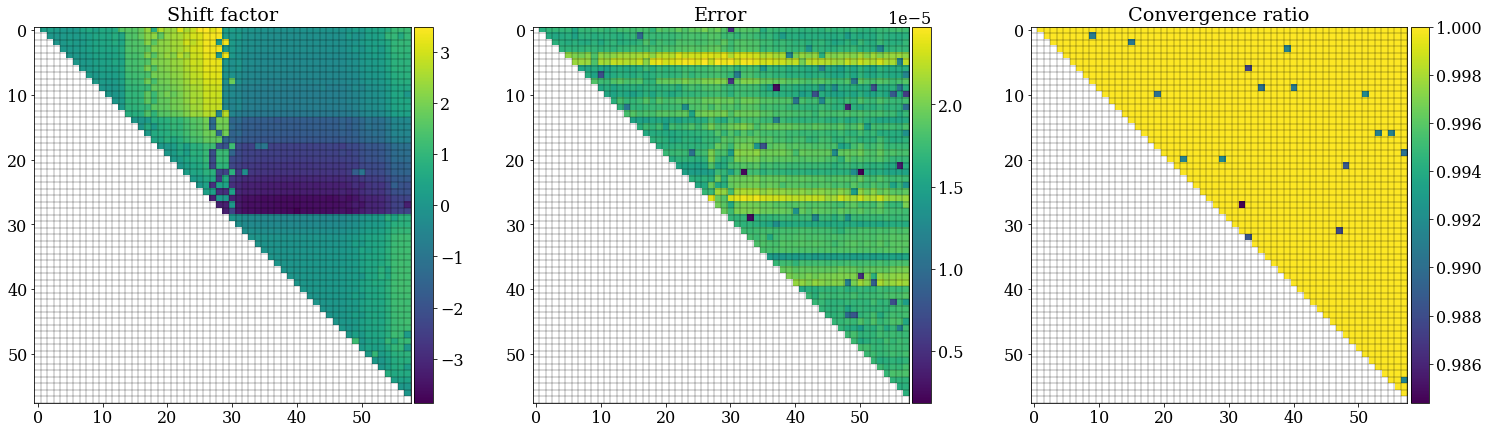

In [530]:
# Reload
result, coords = np.load("lily_data_results/58x58_all_features_fixed2.npy", allow_pickle=True)
plot_matrix(*filter_results(result, coords))

### Plot feature plots for matrix

In [523]:
size = 58
fig, axs = plt.subplots(size, size, figsize=(100, 100))

# Hide labels on all 
for ax in axs.flat:
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

for x in np.arange(size):
    for y in np.arange(x, size):
        
        # Get index from coords
        try:
            index = list(coords).index((x, y))
            plot_features_shift(result[index], axs[x, y], labels=False)
        except:
            continue


# Remove space between graphs
plt.subplots_adjust(wspace=0, hspace=0)

# Write column and row numbers
cols = [col for col in range(0, size)]
rows = [row for row in range(0, size)]
for ax, col in zip(axs[0], cols):
    ax.set_title(col)
for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(f"{row}     ", rotation=0, size='large')


plt.savefig(f"figures/58x58_features_fixed2.png", dpi=100)
plt.close(fig) # don't show figure


### Matrix reduction

#### First: just look at the above diagonal
This is the difference from observation to observation

In [441]:
# Just tempt approach: get the off diagonal
# TODO: add error
# TODO do the matrix reduction ... 
def get_velocity_shifts(matrix):
    """ returns velocity shift for matrix in cm/s """
    size = matrix.shape[0]
    off_diag = []
    for x in np.arange(0, size):
        if x + 1 < size:
            off_diag.append(matrix[x, x + 1])

    off_diag = np.asarray(off_diag)
    # velocity_shifts = angstrom_to_velocity(off_diag)
    return off_diag

In [445]:
def get_time_interval_between_observations(dates):
    """ Returns list of date pairs, between which each observation is made """
    intervals = []
    first_day = datetime(*dates[0])
    for i in np.arange(len(dates) - 1):
        d1 = datetime(*dates[i])
        d2 = datetime(*dates[i+1])
        dd1 = d1 - first_day
        dd2 = d2 - first_day
        intervals.append([dd1.days, dd2.days])
    return np.asarray(intervals)
    

/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_7921/3380937419.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shift_mean, shift_mean_err = weighted_mean(shifts_list[shifts_valid_list == 1], shifts_err_list[[shifts_valid_list == 1]])


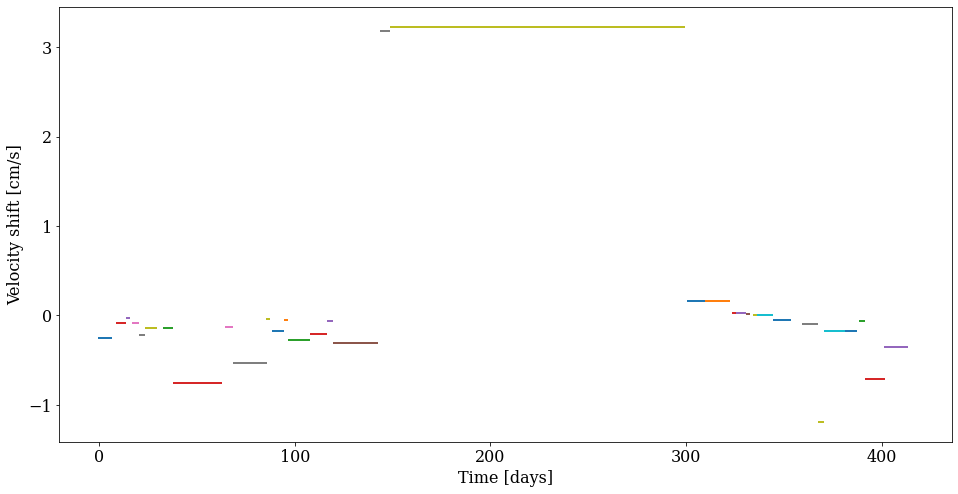

In [524]:
# The velocity shifts are between days, so let's put the x-error bar as the time span for each data point
result, coords = np.load("lily_data_results/58x58_all_features_fixed2.npy", allow_pickle=True)
diff_matrix, diff_matrix_err, diff_matrix_valid = filter_results(result, coords)
velocity_shifts = get_velocity_shifts(diff_matrix)
dates = get_spectra_dates(get_spectra_filenames_without_duplicate_dates())
intervals = get_time_interval_between_observations(dates)

plt.figure(figsize=(16, 8))
plt.xlabel("Time [days]")
plt.ylabel("Velocity shift [cm/s]")
for shift, interval in zip(velocity_shifts, intervals):
    # print(shift, np.diff(interval), interval)
    days_interval = np.arange(*interval)
    plt.plot(days_interval, [shift] * len(days_interval), linewidth=2)


#### Now the matrix reduction using chi2

In [525]:
result, coords = np.load("lily_data_results/58x58_all_features_fixed1.npy", allow_pickle=True)
diff_matrix, diff_matrix_err, diff_matrix_valid = filter_results(result, coords)

def model_chi2(*V):
    V = np.asarray([*V])
    res = []
    size = diff_matrix.shape[0] 
    # V = np.ones(size)
    for x in np.arange(size):
        for y in np.arange(x, size - 1):
            if x != y:
                diff_matrix[x, y]
                V[x]
                V[y]
                res.append(((diff_matrix[x, y] - (V[x] - V[y])) / diff_matrix_err[x, y])**2)
    chi2 = np.sum(res)
    return chi2
model_chi2.errordef = 1

# Use the above diagonal as init values
init_values = get_velocity_shifts(diff_matrix)

minuit = Minuit(model_chi2, *init_values)
minuit.migrad()

/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_7921/3380937419.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shift_mean, shift_mean_err = weighted_mean(shifts_list[shifts_valid_list == 1], shifts_err_list[[shifts_valid_list == 1]])


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.416e+12                  │             Nfcn = 1611              │
│ EDM = 0.00021 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │-914.6580e-3│ 0.0026e-3 │            │            │         │         │       │
│ 1 │ x1   │-794.8350e-3│ 0.0024e-3 │            │            │         │         │       │
│ 2 │ x2   │-719.4209e-3│ 0.0025e-3 │            │            │         │         │       │
│ 3 │ x3   │-633.4100e-3│ 0.0025e-3 │            │            │         │         │       │
│ 4 │ x4   │-636.7783e-3│ 0.0030e-3 │            │            │         │         │       │
│ 5 │ x5   │-637.8242e-3│ 0.0031e-3 │            │            │         │         │       │
│ 6 │ x6   │-577.9849e-3│ 0.0024e-3 │            │            │         │         │       │
│ 7 │ x7   │-490.9658e-3│ 0.0023e-3 │            │            │         │         │       │
│ 8 │ x8   │-408.8353e-3│ 0.0026e-3 │            │            │         │         │       │
│ 9 │ x9   │-319.1192e-3│ 0.0019e-3 │            │            │         │         │       │
│ 10│ x10  │-274.6363e-3│ 0.0023e-3 │            │            │         │         │       │
│ 11│ x11  │-70.0874e-3│ 0.0023e-3 │            │            │         │         │       │
│ 12│ x12  │984.2008e-3│ 0.0020e-3 │            │            │         │         │       │
│ 13│ x13  │-86.3435e-3│ 0.0027e-3 │            │            │         │         │       │
│ 14│ x14  │692.8182e-3│ 0.0024e-3 │            │            │         │         │       │
│ 15│ x15  │-1.2321564 │ 0.0000025 │            │            │         │         │       │
│ 16│ x16  │750.0241e-3│ 0.0024e-3 │            │            │         │         │       │
│ 17│ x17  │883.6676e-3│ 0.0025e-3 │            │            │         │         │       │
│ 18│ x18  │ 1.3543472 │ 0.0000026 │            │            │         │         │       │
│ 19│ x19  │ 1.3802367 │ 0.0000026 │            │            │         │         │       │
│ 20│ x20  │ 1.4730314 │ 0.0000026 │            │            │         │         │       │
│ 21│ x21  │ 1.6417977 │ 0.0000022 │            │            │         │         │       │
│ 22│ x22  │ 1.0945627 │ 0.0000018 │            │            │         │         │       │
│ 23│ x23  │ 1.9176768 │ 0.0000027 │            │            │         │         │       │
│ 24│ x24  │ 2.0533432 │ 0.0000026 │            │            │         │         │       │
│ 25│ x25  │ 2.1006784 │ 0.0000028 │            │            │         │         │       │
│ 26│ x26  │ 2.3016119 │ 0.0000030 │            │            │         │         │       │
│ 27│ x27  │ 1.9143181 │ 0.0000028 │            │            │         │         │       │
│ 28│ x28  │ 1.7437703 │ 0.0000028 │            │            │         │         │       │
│ 29│ x29  │210.1845e-3│ 0.0025e-3 │            │            │         │         │       │
│ 30│ x30  │-442.8112e-3│ 0.0025e-3 │            │            │         │ 

In [526]:
# The velocity shifts are between days, so let's put the x-error bar as the time span for each data point
result, coords = np.load("lily_data_results/58x58_all_features.npy", allow_pickle=True)
diff_matrix, diff_matrix_err, diff_matrix_valid = filter_results(result, coords)
velocity_shifts = get_velocity_shifts(diff_matrix)
dates = get_spectra_dates(get_spectra_filenames_without_duplicate_dates())
intervals = get_time_interval_between_observations(dates)

/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_7921/3380937419.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shift_mean, shift_mean_err = weighted_mean(shifts_list[shifts_valid_list == 1], shifts_err_list[[shifts_valid_list == 1]])


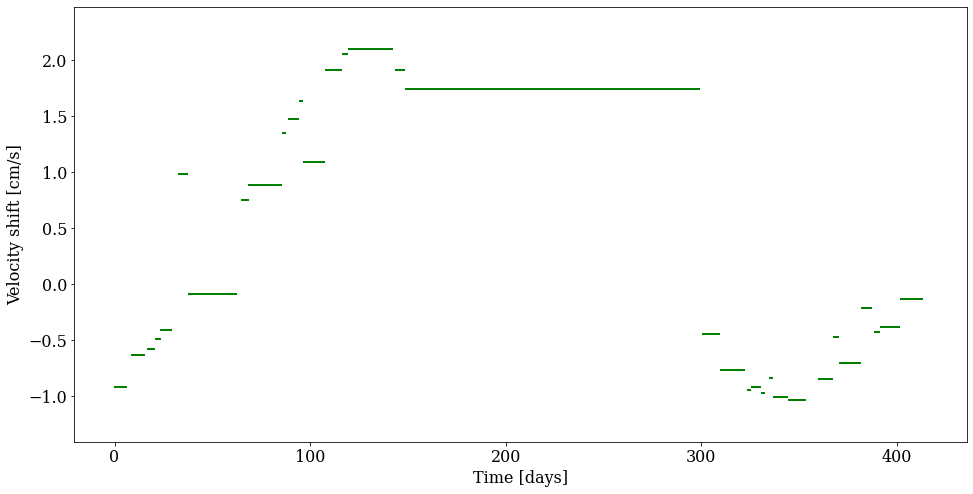

In [528]:
fig = plt.figure(figsize=(16, 8))
plt.xlabel("Time [days]")
plt.ylabel("Velocity shift [cm/s]")
# plt.plot(intervals, minuit.values[:], "o")


# for shift, interval in zip(velocity_shifts, intervals):
#     # print(shift, np.diff(interval), interval)
#     days_interval = np.arange(*interval)
#     plt.plot(days_interval, [shift] * len(days_interval), linewidth=2, color="red")


for shift, interval in zip(minuit.values[:], intervals):
    # print(shift, np.diff(interval), interval)
    days_interval = np.arange(*interval)
    plt.plot(days_interval, [shift] * len(days_interval), linewidth=2, color="green")


### UMAP feature selection

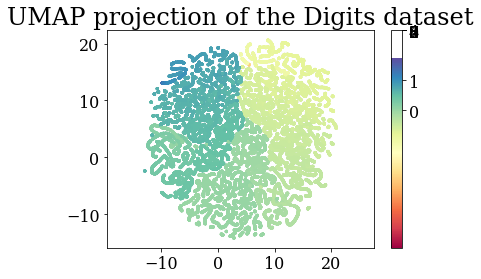

In [310]:
result, coords = np.load("lily_data_results/58x58_all_features.npy", allow_pickle=True)

xshift = []
for r in result[:50]:
    xshift.append(r[:, 0])

xshift = np.concatenate(xshift)

# df = pd.DataFrame(result[1218], copy=True)
# df.columns = ["x", "err", "valid"]

# # Filter larger values
# df.valid[:] = 1 # reset ... 
# df.valid[df.x > 0.25] = 0 
# df.valid[df.x < -0.25] = 0 
# n = np.asarray(df)

import umap
# reducer = umap.UMAP()
# embedding = reducer.fit_transform(df.x)
# embedding.shape

reducer = umap.UMAP(random_state=42)
xshift = xshift.reshape(-1, 1)
reducer.fit(xshift)

umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)


embedding = reducer.transform(xshift)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
# embedding.shape

plt.scatter(embedding[:, 0], embedding[:, 1], c=xshift, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

# # plot_features_shift(n)